<H2> Import Library yang dibutuhkan

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

<p>Dicoba untuk membaca dataset train dan test dalam bentuk csv untuk setiap train dan test. Untuk mempermudah path dari setiap gambar yang memiliki folder berbeda dari root maka dicoba untuk melakukan join path. </p>

In [ ]:
df_train = pd.read_csv("dataset/train_data/train.csv")
df_test = pd.read_csv("dataset/test_data_v2/test.csv")

In [ ]:
df_train['file_path'] = df_train['file_name'].apply(lambda x: os.path.join("dataset/train_data", os.path.basename(x)))
df_train = df_train[df_train['file_path'].apply(os.path.exists)].reset_index(drop=True)

<h3>Pengecekan data info baik berupa nilai null dan duplicate</h3>
<p>dilakukan pengecekan info data untuk analisa keperluan, kemudian pengecekan data pada 5 data pertama, nilai kosong dan nilai yang terduplikasi</p>

In [ ]:
print("--- Training Data Info ---")
df_train.info()
print("\n--- Training Data Head ---")
print(df_train.head())
print("\n--- Training Data Null Values ---")
print(df_train.isnull().sum())
print("\n--- Training Data Duplicated Values ---")
print(df_train.duplicated().sum())

--- Balanced Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
 3   file_path   79950 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.4+ MB

--- Balanced Training Data Head ---
   Unnamed: 0                                        file_name  label  \
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1   
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0   
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1   
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0   
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1   

                                           file_path  
0  dataset/train_data\a6dcb93f596a4

<p>Pengecekan distribusi antar label</p>

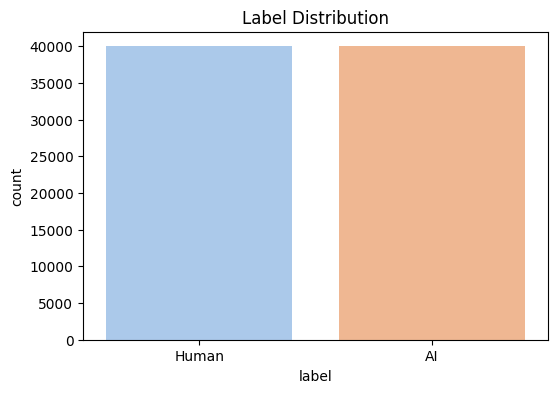

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_train, palette="pastel", hue="label", legend=False)
plt.title("Label Distribution")
plt.xticks([0, 1], ["Human", "AI"])
plt.show()

<p>dicoba untuk melihat hasil 10 data random pada dile train</p>

In [ ]:
print("\n--- Total Value Distribution ---")
print(df_train['label'].value_counts())


--- Total Value Distribution ---
label
1    39975
0    39975
Name: count, dtype: int64


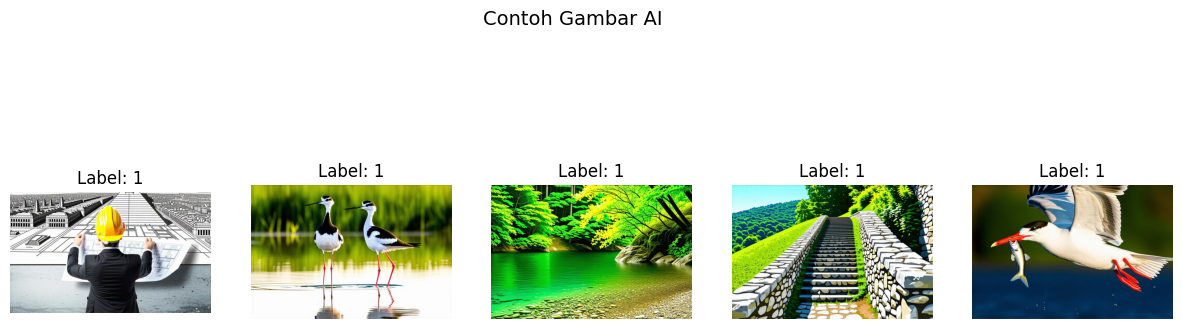

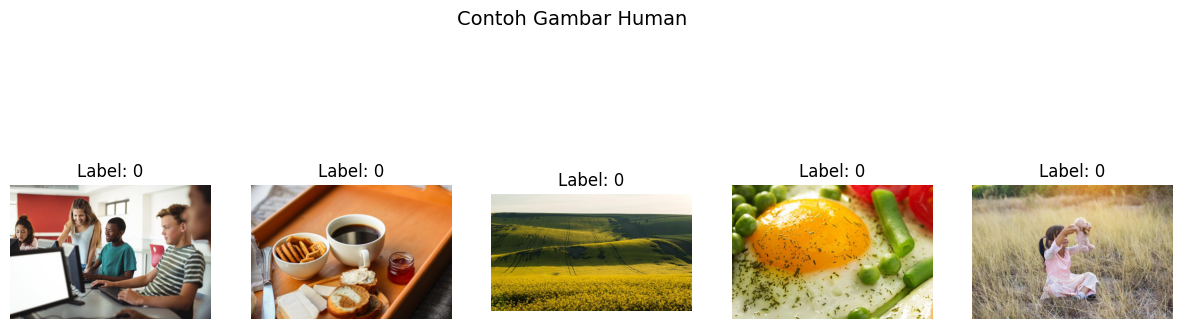

In [ ]:
from PIL import Image
import random
from matplotlib import pyplot as plt

def show_images(df, label, num_images=5):
    sample = df[df['label'] == label].sample(num_images)
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample.iterrows()):
        img = Image.open(row[1]['file_path'])
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {label}")
    plt.suptitle("Contoh Gambar AI" if label == 1 else "Contoh Gambar Human", fontsize=14)
    plt.show()

show_images(df_train, label=1)
show_images(df_train, label=0)

In [ ]:
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)
print(f"Train size after split: {len(train_df)}, Val size after split: {len(val_df)}")

Train size after split: 63960, Val size after split: 15990


Menggunakan ImageCSVLoader untuk mengambil data gambar berdasarkan path yang ada di csv. Kemudian dilakukan transform pada gambar untuk supply data pada tahap pembuatan model. 

In [ ]:
class ImageCSVLoader(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

Transformasi data train & validate. Diaplikasikan menggunakan imageloader dan data loader untuk menghimpun dari batch kecil yang telah dipilih secara acak pada train dan tidak acak pada val. 

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train_dataset = ImageCSVLoader(train_df, transform=train_transform)
val_dataset = ImageCSVLoader(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

<p>Check untuk pengunaan cuda GPU dengan torch</p>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<h3>Deklarasi masing - masing model</h3>

<p>1. Simple CNN</p>

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 224x224 -> 112x112

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 112x112 -> 56x56

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 56x56 -> 28x28

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Menambahkan dropout untuk regularisasi
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        return x 

model_cnn = SimpleCNN(num_classes=2).to(device)
print(model_cnn)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate)

In [ ]:
train_losses_cnn = []
val_losses_cnn = []
train_accuracies_cnn = []
val_accuracies_cnn = []

for epoch in range(num_epochs):
    model_cnn.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long() 

        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_cnn.append(epoch_train_loss)
    train_accuracies_cnn.append(epoch_train_acc)

    model_cnn.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds = []
    all_val_labels = []

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_cnn.append(epoch_val_loss)
    val_accuracies_cnn.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

print("Training Selesai!")

Epoch 1/20 [Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:17<00:00,  3.63it/s, val_loss=0.188, val_acc=0.955]


Epoch [1/20], Train Loss: 0.2534, Train Acc: 0.8997, Val Loss: 0.2446, Val Acc: 0.8976


Epoch 2/20 [Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:17<00:00,  3.63it/s, val_loss=0.118, val_acc=0.955]


Epoch [2/20], Train Loss: 0.2209, Train Acc: 0.9134, Val Loss: 0.2056, Val Acc: 0.9146


Epoch 3/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:38<00:00,  2.29it/s, val_loss=0.0538, val_acc=0.955]


Epoch [3/20], Train Loss: 0.1908, Train Acc: 0.9270, Val Loss: 0.1601, Val Acc: 0.9371


Epoch 4/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:39<00:00,  2.28it/s, val_loss=0.0679, val_acc=0.955]


Epoch [4/20], Train Loss: 0.1616, Train Acc: 0.9386, Val Loss: 0.1851, Val Acc: 0.9327


Epoch 5/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:44<00:00,  2.22it/s, val_loss=0.0925, val_acc=0.955]


Epoch [5/20], Train Loss: 0.1507, Train Acc: 0.9435, Val Loss: 0.1661, Val Acc: 0.9388


Epoch 6/20 [Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s, val_loss=0.328, val_acc=0.955]


Epoch [6/20], Train Loss: 0.1336, Train Acc: 0.9520, Val Loss: 0.2191, Val Acc: 0.9129


Epoch 7/20 [Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.02it/s, val_loss=0.071, val_acc=0.955]


Epoch [7/20], Train Loss: 0.1251, Train Acc: 0.9544, Val Loss: 0.1259, Val Acc: 0.9562


Epoch 8/20 [Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  1.99it/s, val_loss=0.152, val_acc=0.955]


Epoch [8/20], Train Loss: 0.1237, Train Acc: 0.9543, Val Loss: 0.1399, Val Acc: 0.9497


Epoch 9/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.00it/s, val_loss=0.0118, val_acc=1]


Epoch [9/20], Train Loss: 0.1176, Train Acc: 0.9563, Val Loss: 0.1183, Val Acc: 0.9580


Epoch 10/20 [Validation]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.98it/s, val_loss=0.00358, val_acc=1]


Epoch [10/20], Train Loss: 0.1102, Train Acc: 0.9596, Val Loss: 0.1188, Val Acc: 0.9586


Epoch 11/20 [Validation]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:13<00:00,  1.98it/s, val_loss=0.00322, val_acc=1]


Epoch [11/20], Train Loss: 0.1080, Train Acc: 0.9601, Val Loss: 0.0991, Val Acc: 0.9657


Epoch 12/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s, val_loss=0.112, val_acc=0.955]


Epoch [12/20], Train Loss: 0.1039, Train Acc: 0.9616, Val Loss: 0.1150, Val Acc: 0.9587


Epoch 13/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, val_loss=0.087, val_acc=0.955]


Epoch [13/20], Train Loss: 0.1031, Train Acc: 0.9630, Val Loss: 0.1956, Val Acc: 0.9297


Epoch 14/20 [Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.02it/s, val_loss=0.0246, val_acc=1]


Epoch [14/20], Train Loss: 0.0983, Train Acc: 0.9640, Val Loss: 0.0917, Val Acc: 0.9709


Epoch 15/20 [Validation]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:07<00:00,  2.02it/s, val_loss=0.00529, val_acc=1]


Epoch [15/20], Train Loss: 0.0964, Train Acc: 0.9660, Val Loss: 0.0735, Val Acc: 0.9758


Epoch 16/20 [Validation]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s, val_loss=0.00961, val_acc=1]


Epoch [16/20], Train Loss: 0.0956, Train Acc: 0.9650, Val Loss: 0.0873, Val Acc: 0.9691


Epoch 17/20 [Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, val_loss=0.0551, val_acc=0.955]


Epoch [17/20], Train Loss: 0.0949, Train Acc: 0.9660, Val Loss: 0.0948, Val Acc: 0.9699


Epoch 18/20 [Validation]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  1.99it/s, val_loss=0.00124, val_acc=1]


Epoch [18/20], Train Loss: 0.0918, Train Acc: 0.9666, Val Loss: 0.0866, Val Acc: 0.9701


Epoch 19/20 [Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s, val_loss=0.173, val_acc=0.955]


Epoch [19/20], Train Loss: 0.0897, Train Acc: 0.9671, Val Loss: 0.1607, Val Acc: 0.9391


Epoch 20/20 [Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s, val_loss=0.0245, val_acc=1]

Epoch [20/20], Train Loss: 0.0895, Train Acc: 0.9679, Val Loss: 0.0859, Val Acc: 0.9708
Training Selesai!



--- Confusion Matrix ---
              precision    recall  f1-score   support

   Human (0)       0.97      0.97      0.97      7995
      AI (1)       0.97      0.97      0.97      7995

    accuracy                           0.97     15990
   macro avg       0.97      0.97      0.97     15990
weighted avg       0.97      0.97      0.97     15990


--- Confusion Matrix ---


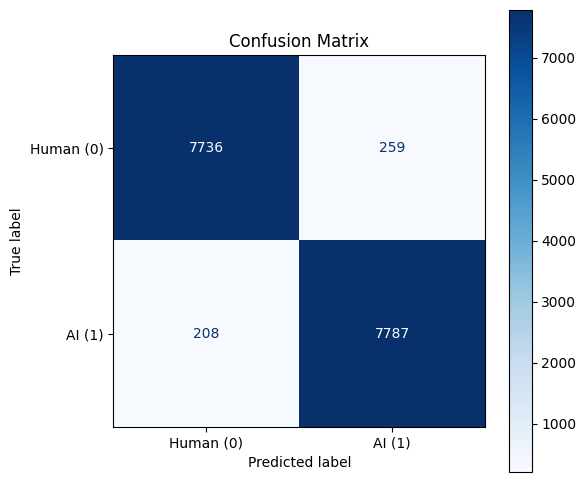

In [ ]:
print("\n--- Confusion Matrix ---")
target_names = ['Human (0)', 'AI (1)']
print(classification_report(all_val_labels, all_val_preds, target_names=target_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_val_labels, all_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

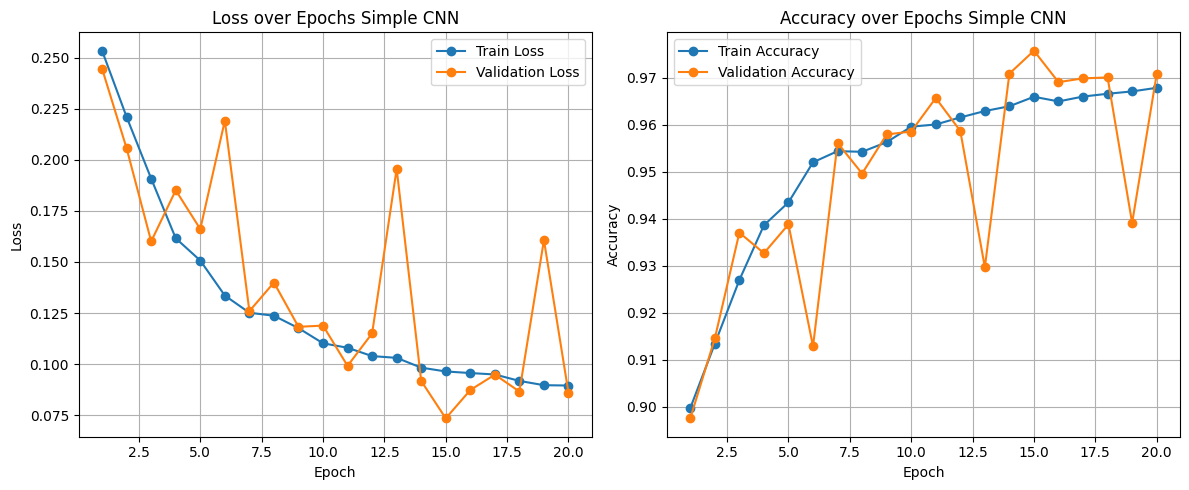

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn):
    epochs = range(1, len(train_losses_cnn) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_cnn, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_cnn, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs Simple CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies_cnn, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies_cnn, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs Simple CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_roc_auc(model_cnn, data_loader, device):
    model_cnn.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model_cnn(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc

In [ ]:
# display_test_predictions(model_cnn, test_loader, device, target_names=['Human', 'AI'], model_name="Simple CNN")

In [ ]:
# # Testing modelnya
# def display_test_predictions(model_cnn, test_loader, device, num_images=10, target_names=['Human', 'AI']):
#     model_cnn.eval()
#     images_displayed = 0
#     plt.figure(figsize=(15, 8))
#     plt.suptitle("Test Image Predictions (Simple CNN)", fontsize=16)

#     with torch.no_grad():
#         random_test_loader = DataLoader(test_loader.dataset, batch_size=1, shuffle=True)

#         for images, labels in random_test_loader:
#             if images_displayed >= num_images:
#                 break

#             images = images.to(device)
#             labels = labels.to(device).long()

#             outputs = model_cnn(images)
#             _, predicted = torch.max(outputs.data, 1)

#             img = images.cpu().squeeze(0)
#             mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1)
#             std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1)
#             img = img * std + mean
#             img = torch.clamp(img, 0, 1)

#             img_np = img.permute(1, 2, 0).numpy()

#             plt.subplot(2, 5, images_displayed + 1)
#             plt.imshow(img_np)
#             plt.title(f'Pred: {target_names[predicted.item()]}\nActual: {target_names[labels.item()]}', fontsize=10)
#             plt.axis('off')
#             images_displayed += 1

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

# df_test['file_path'] = df_test['file_name'].apply(lambda x: os.path.join("dataset/test_data_v2", os.path.basename(x)))
# df_test = df_test[df_test['file_path'].apply(os.path.exists)].reset_index(drop=True)

# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# test_dataset = ImageCSVLoader(df_test, transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# display_test_predictions(model_cnn, test_loader, device, num_images=10, target_names=['Human', 'AI'])


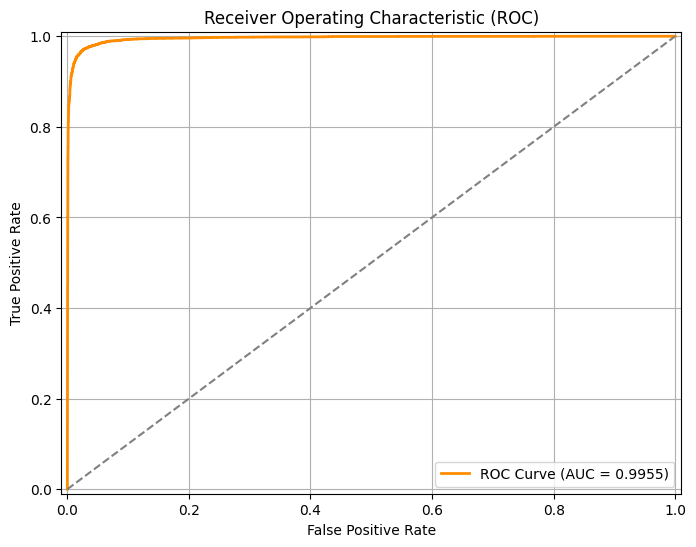

AUC Score (CNN): 0.9955


In [ ]:
roc_auc_cnn = plot_roc_auc(model_cnn, val_loader, device)
print(f"AUC Score (CNN): {roc_auc_cnn:.4f}")

In [ ]:
model_save_path = "simple_cnn_model_new.pth"

torch.save(model_cnn.state_dict(), model_save_path)
print(f"Model berhasil disimpan di: {model_save_path}")

torch.save(model_cnn.state_dict(), "simple_cnn_model_new.pth")

history_cnn = {
    "train_loss": train_losses_cnn,
    "val_loss": val_losses_cnn,
    "train_acc": train_accuracies_cnn,
    "val_acc": val_accuracies_cnn
}

print(f"hasil seluruh loss dan acc disimpan pada history_cnn")

Model berhasil disimpan di: simple_cnn_model_new.pth
hasil seluruh loss dan acc disimpan pada history_cnn


In [ ]:
# Pemanggilan model
# model = SimpleCNN(num_classes=2)
# model.load_state_dict(torch.load("simple_cnn_model_modified.pth"))
# model.eval().to(device)

C:\Users\User\Documents\cherry\cherry-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


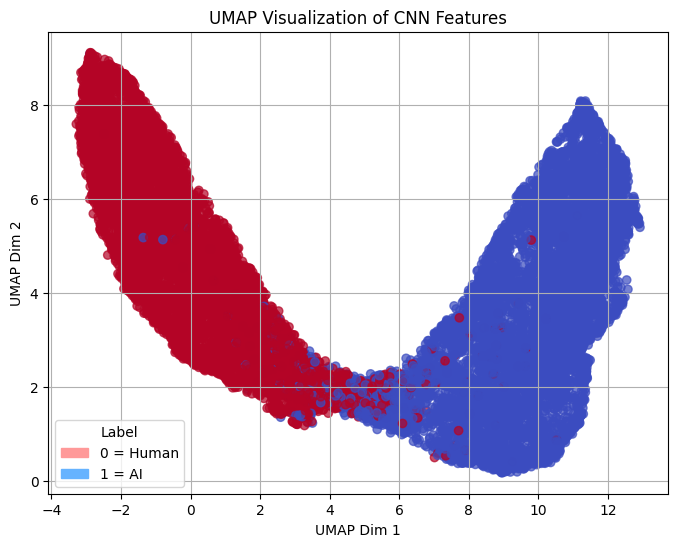

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

features = []
labels_list = []

model_cnn.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        features_batch = model_cnn.extract_features(images)
        features.append(features_batch.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels_list)

reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = reducer.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_umap[:, 0], features_umap[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.title("UMAP Visualization of CNN Features")
plt.grid(True)

label_names = {0: "Human", 1: "AI"}
colors = ['#ff9999', '#66b3ff']

legend_handles = [
    mpatches.Patch(color=colors[0], label="0 = Human"),
    mpatches.Patch(color=colors[1], label="1 = AI")
]

plt.legend(handles=legend_handles, title="Label")
plt.show()

<h3>2. EfficientNet-B0</h3>

<p>Model declaration EfficientNet-B0</p>

In [ ]:
import timm
import torch.nn as nn

model_eff = timm.create_model("efficientnet_b0", pretrained=True, num_classes=2)

for param in model_eff.parameters():
    param.requires_grad = False

for param in model_eff.classifier.parameters():
    param.requires_grad = True

model_eff = model_eff.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_eff = torch.optim.Adam(model_eff.classifier.parameters(), lr=1e-4)

<p>Model Loop Training (20 epochs)</p>

In [ ]:
train_losses_eff = []
val_losses_eff = []
train_accuracies_eff = []
val_accuracies_eff = []

for epoch in range(num_epochs):
    model_eff.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [EfficientNet Training]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_eff(images)
        loss = criterion(outputs, labels)

        optimizer_eff.zero_grad()
        loss.backward()
        optimizer_eff.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_eff.append(epoch_train_loss)
    train_accuracies_eff.append(epoch_train_acc)

    model_eff.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds_eff = []
    all_val_labels_eff = []

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [EfficientNet Validation]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model_eff(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_val_preds_eff.extend(predicted.cpu().numpy())
            all_val_labels_eff.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_eff.append(epoch_val_loss)
    val_accuracies_eff.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Training EfficientNet Selesai! 🎉")

Epoch 1/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:07<00:00,  2.02it/s, val_loss=1.57, val_acc=0.591]


Epoch [1/20] | Train Loss: 2.0698 | Train Acc: 0.5864 | Val Loss: 1.5326 | Val Acc: 0.6568


Epoch 2/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, val_loss=1.41, val_acc=0.636]


Epoch [2/20] | Train Loss: 1.1983 | Train Acc: 0.7140 | Val Loss: 1.1493 | Val Acc: 0.7220


Epoch 3/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:19<00:00,  1.93it/s, val_loss=1.43, val_acc=0.636]


Epoch [3/20] | Train Loss: 0.9494 | Train Acc: 0.7651 | Val Loss: 0.9541 | Val Acc: 0.7611


Epoch 4/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, val_loss=1.34, val_acc=0.727]


Epoch [4/20] | Train Loss: 0.8279 | Train Acc: 0.7874 | Val Loss: 0.8996 | Val Acc: 0.7698


Epoch 5/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, val_loss=1.21, val_acc=0.727]


Epoch [5/20] | Train Loss: 0.7421 | Train Acc: 0.8042 | Val Loss: 0.7917 | Val Acc: 0.7899


Epoch 6/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:19<00:00,  1.93it/s, val_loss=1.02, val_acc=0.727]


Epoch [6/20] | Train Loss: 0.6824 | Train Acc: 0.8150 | Val Loss: 0.7114 | Val Acc: 0.8011


Epoch 7/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, val_loss=0.931, val_acc=0.727]


Epoch [7/20] | Train Loss: 0.6373 | Train Acc: 0.8220 | Val Loss: 0.6719 | Val Acc: 0.8083


Epoch 8/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.00it/s, val_loss=1.16, val_acc=0.727]


Epoch [8/20] | Train Loss: 0.6062 | Train Acc: 0.8277 | Val Loss: 0.6871 | Val Acc: 0.8087


Epoch 9/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:18<00:00,  1.94it/s, val_loss=0.843, val_acc=0.727]


Epoch [9/20] | Train Loss: 0.5711 | Train Acc: 0.8313 | Val Loss: 0.5986 | Val Acc: 0.8190


Epoch 10/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, val_loss=0.736, val_acc=0.773]


Epoch [10/20] | Train Loss: 0.5433 | Train Acc: 0.8351 | Val Loss: 0.5720 | Val Acc: 0.8259


Epoch 11/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s, val_loss=0.728, val_acc=0.773]


Epoch [11/20] | Train Loss: 0.5200 | Train Acc: 0.8412 | Val Loss: 0.5427 | Val Acc: 0.8318


Epoch 12/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:19<00:00,  1.92it/s, val_loss=0.561, val_acc=0.818]


Epoch [12/20] | Train Loss: 0.4965 | Train Acc: 0.8432 | Val Loss: 0.5010 | Val Acc: 0.8386


Epoch 13/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:18<00:00,  1.93it/s, val_loss=0.664, val_acc=0.818]


Epoch [13/20] | Train Loss: 0.4799 | Train Acc: 0.8471 | Val Loss: 0.5003 | Val Acc: 0.8412


Epoch 14/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:16<00:00,  1.95it/s, val_loss=0.6, val_acc=0.864]


Epoch [14/20] | Train Loss: 0.4664 | Train Acc: 0.8485 | Val Loss: 0.4821 | Val Acc: 0.8431


Epoch 15/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:18<00:00,  1.93it/s, val_loss=0.53, val_acc=0.818]


Epoch [15/20] | Train Loss: 0.4504 | Train Acc: 0.8517 | Val Loss: 0.4559 | Val Acc: 0.8478


Epoch 16/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:16<00:00,  1.95it/s, val_loss=0.534, val_acc=0.818]


Epoch [16/20] | Train Loss: 0.4318 | Train Acc: 0.8544 | Val Loss: 0.4344 | Val Acc: 0.8532


Epoch 17/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:20<00:00,  1.92it/s, val_loss=0.428, val_acc=0.864]


Epoch [17/20] | Train Loss: 0.4272 | Train Acc: 0.8549 | Val Loss: 0.4282 | Val Acc: 0.8542


Epoch 18/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:18<00:00,  1.93it/s, val_loss=0.521, val_acc=0.818]


Epoch [18/20] | Train Loss: 0.4073 | Train Acc: 0.8592 | Val Loss: 0.4348 | Val Acc: 0.8487


Epoch 19/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:16<00:00,  1.95it/s, val_loss=0.434, val_acc=0.818]


Epoch [19/20] | Train Loss: 0.3981 | Train Acc: 0.8602 | Val Loss: 0.4105 | Val Acc: 0.8543


Epoch 20/20 [EfficientNet Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:16<00:00,  1.95it/s, val_loss=0.493, val_acc=0.864]

Epoch [20/20] | Train Loss: 0.3857 | Train Acc: 0.8628 | Val Loss: 0.4012 | Val Acc: 0.8573
Training EfficientNet Selesai! 🎉


<p>Evaluation Confusion Matrix, ROC & AUC, UMAP</p>


--- Confusion Matrix EfficientNet ---
              precision    recall  f1-score   support

   Human (0)       0.89      0.81      0.85      7995
      AI (1)       0.83      0.90      0.86      7995

    accuracy                           0.86     15990
   macro avg       0.86      0.86      0.86     15990
weighted avg       0.86      0.86      0.86     15990



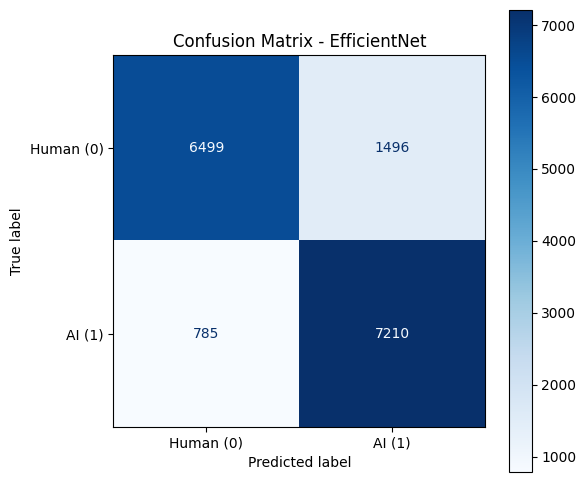

In [ ]:
print("\n--- Confusion Matrix EfficientNet ---")
print(classification_report(all_val_labels_eff, all_val_preds_eff, target_names=['Human (0)', 'AI (1)']))

cm_eff = confusion_matrix(all_val_labels_eff, all_val_preds_eff)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eff, display_labels=['Human (0)', 'AI (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='horizontal')
plt.title('Confusion Matrix - EfficientNet')
plt.show()

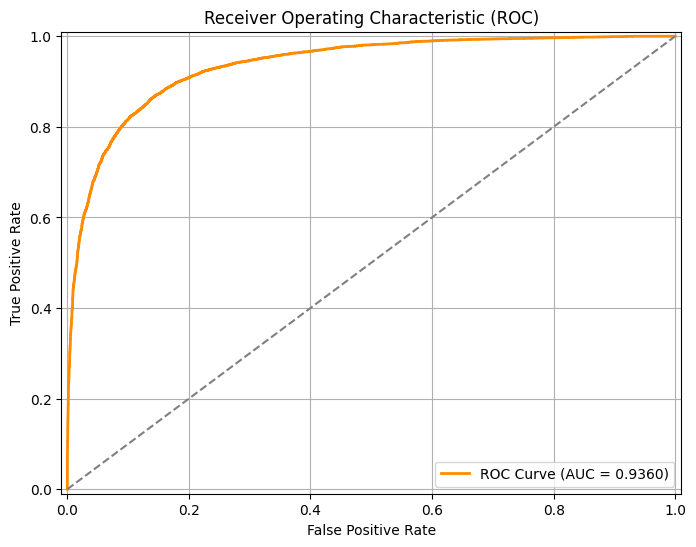

AUC Score (EfficientNet): 0.9360


In [ ]:
roc_auc_eff = plot_roc_auc(model_eff, val_loader, device)
print(f"AUC Score (EfficientNet): {roc_auc_eff:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses_eff, val_losses_eff, train_accuracies_eff, val_accuracies_eff):
    epochs = range(1, len(train_losses_eff) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_eff, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_eff, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs EfficientNet B0')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies_eff, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies_eff, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs EfficientNet B0')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_losses_eff, val_losses_eff, train_accuracies_eff, val_accuracies_eff)


NameError: name 'train_losses_vit' is not defined

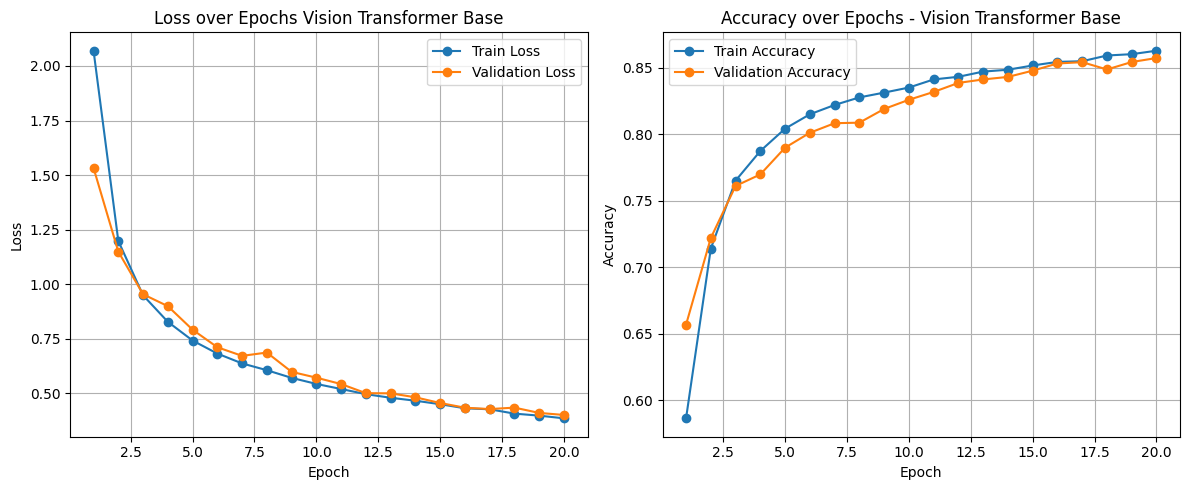

In [ ]:
import matplotlib.pyplot as plt

train_losses_eff = [2.0698, 1.1983, 0.9494, 0.8279, 0.7421, 0.6824, 0.6373, 0.6062, 0.5711, 0.5433,
                    0.5200, 0.4965, 0.4799, 0.4664, 0.4504, 0.4318, 0.4272, 0.4073, 0.3981, 0.3857]

val_losses_eff = [1.5326, 1.1493, 0.9541, 0.8996, 0.7917, 0.7114, 0.6719, 0.6871, 0.5986, 0.5720,
                  0.5427, 0.5010, 0.5003, 0.4821, 0.4559, 0.4344, 0.4282, 0.4348, 0.4105, 0.4012]

train_accuracies_eff = [0.5864, 0.7140, 0.7651, 0.7874, 0.8042, 0.8150, 0.8220, 0.8277, 0.8313, 0.8351,
                        0.8412, 0.8432, 0.8471, 0.8485, 0.8517, 0.8544, 0.8549, 0.8592, 0.8602, 0.8628]

val_accuracies_eff = [0.6568, 0.7220, 0.7611, 0.7698, 0.7899, 0.8011, 0.8083, 0.8087, 0.8190, 0.8259,
                      0.8318, 0.8386, 0.8412, 0.8431, 0.8478, 0.8532, 0.8542, 0.8487, 0.8543, 0.8573]

# Fungsi plotting
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs Vision Transformer Base')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs - Vision Transformer Base')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot data EfficientNet
plot_training_history(train_losses_eff, val_losses_eff, train_accuracies_eff, val_accuracies_eff)

C:\Users\User\Documents\cherry\cherry-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


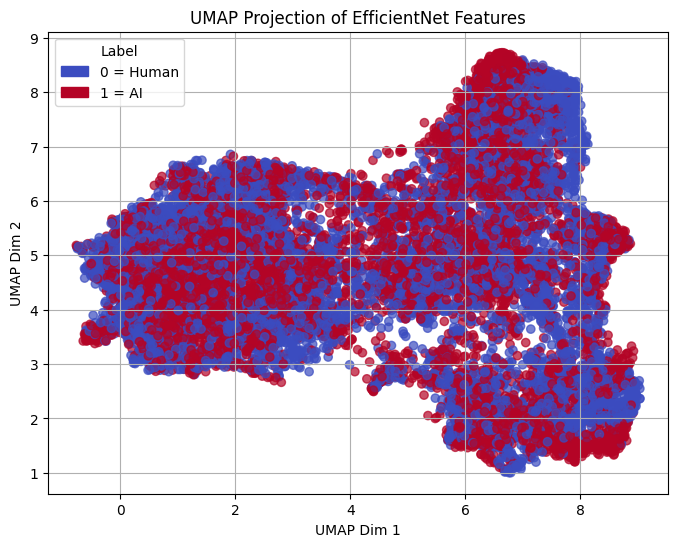

In [ ]:
import torch.nn.functional as F
model_eff.eval()

features_eff = []
labels_eff = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        feats = model_eff.forward_features(images)
        
        feats = F.adaptive_avg_pool2d(feats, 1)  
        feats = feats.view(feats.size(0), -1)    

        features_eff.append(feats.cpu().numpy())
        labels_eff.extend(labels.cpu().numpy())

features_eff = np.concatenate(features_eff, axis=0)
labels_eff = np.array(labels_eff)

reducer = umap.UMAP(n_components=2, random_state=42)
features_umap_eff = reducer.fit_transform(features_eff)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_umap_eff[:, 0], features_umap_eff[:, 1],
    c=labels_eff, cmap='coolwarm', alpha=0.7
)
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.title("UMAP Projection of EfficientNet Features")
plt.grid(True)

legend_handles = [
    mpatches.Patch(color='#3b4cc0', label="0 = Human"),
    mpatches.Patch(color='#b40426', label="1 = AI")
]
plt.legend(handles=legend_handles, title="Label")
plt.show()


In [ ]:
# display_test_predictions(model_eff, test_loader, device, target_names=['Human', 'AI'], model_name="EfficientNet-B0")

In [ ]:
torch.save(model_eff.state_dict(), "EfficientNetB0_model_new.pth")
print("Model EfficientNet berhasil disimpan ke: EfficientNetB0_model_new.pth")

history_eff = {
    "train_loss": train_losses_eff,
    "val_loss": val_losses_eff,
    "train_acc": train_accuracies_eff,
    "val_acc": val_accuracies_eff
}
print("History EfficientNet disimpan dalam variabel 'history_eff'")

Model EfficientNet berhasil disimpan ke: EfficientNetB0_model_new.pth
History EfficientNet disimpan dalam variabel 'history_eff'


<h3>3. Vision Transformer Base using Timm</h3>

<p>Initiate Vision Transformer model PRETRAIN</p>

In [ ]:
import timm
import torch.nn as nn

model_vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)

for param in model_vit.parameters():
    param.requires_grad = False

for param in model_vit.head.parameters():
    param.requires_grad = True

model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(model_vit.head.parameters(), lr=1e-4)

<p>Training Loop 20 Epochs</p>

In [ ]:
train_losses_vit = []
val_losses_vit = []
train_accuracies_vit = []
val_accuracies_vit = []

for epoch in range(num_epochs):
    model_vit.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [ViT Training]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_vit(images)
        loss = criterion(outputs, labels)

        optimizer_vit.zero_grad()
        loss.backward()
        optimizer_vit.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_vit.append(epoch_train_loss)
    train_accuracies_vit.append(epoch_train_acc)

    model_vit.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds_vit = []
    all_val_labels_vit = []

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [ViT Validation]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model_vit(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_val_preds_vit.extend(predicted.cpu().numpy())
            all_val_labels_vit.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_vit.append(epoch_val_loss)
    val_accuracies_vit.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Training ViT Selesai! 🎉")


Epoch 1/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.182, val_acc=1]


Epoch [1/20] | Train Loss: 0.3887 | Train Acc: 0.8326 | Val Loss: 0.2446 | Val Acc: 0.9150


Epoch 2/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:27<00:00,  1.29it/s, val_loss=0.146, val_acc=1]


Epoch [2/20] | Train Loss: 0.2295 | Train Acc: 0.9201 | Val Loss: 0.1879 | Val Acc: 0.9358


Epoch 3/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:24<00:00,  1.30it/s, val_loss=0.133, val_acc=1]


Epoch [3/20] | Train Loss: 0.1939 | Train Acc: 0.9316 | Val Loss: 0.1673 | Val Acc: 0.9417


Epoch 4/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:29<00:00,  1.29it/s, val_loss=0.113, val_acc=1]


Epoch [4/20] | Train Loss: 0.1778 | Train Acc: 0.9356 | Val Loss: 0.1549 | Val Acc: 0.9448


Epoch 5/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:13<00:00,  1.34it/s, val_loss=0.109, val_acc=1]


Epoch [5/20] | Train Loss: 0.1683 | Train Acc: 0.9382 | Val Loss: 0.1471 | Val Acc: 0.9469


Epoch 6/20 [ViT Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:32<00:00,  1.27it/s, val_loss=0.0979, val_acc=1]


Epoch [6/20] | Train Loss: 0.1619 | Train Acc: 0.9394 | Val Loss: 0.1431 | Val Acc: 0.9482


Epoch 7/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:22<00:00,  1.31it/s, val_loss=0.106, val_acc=1]


Epoch [7/20] | Train Loss: 0.1582 | Train Acc: 0.9417 | Val Loss: 0.1380 | Val Acc: 0.9500


Epoch 8/20 [ViT Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:27<00:00,  1.29it/s, val_loss=0.103, val_acc=0.955]


Epoch [8/20] | Train Loss: 0.1544 | Train Acc: 0.9420 | Val Loss: 0.1375 | Val Acc: 0.9497


Epoch 9/20 [ViT Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:24<00:00,  1.30it/s, val_loss=0.0826, val_acc=1]


Epoch [9/20] | Train Loss: 0.1526 | Train Acc: 0.9421 | Val Loss: 0.1340 | Val Acc: 0.9507


Epoch 10/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.0896, val_acc=1]


Epoch [10/20] | Train Loss: 0.1516 | Train Acc: 0.9426 | Val Loss: 0.1337 | Val Acc: 0.9507


Epoch 11/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.0862, val_acc=1]


Epoch [11/20] | Train Loss: 0.1491 | Train Acc: 0.9437 | Val Loss: 0.1332 | Val Acc: 0.9500


Epoch 12/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.0875, val_acc=0.955]


Epoch [12/20] | Train Loss: 0.1486 | Train Acc: 0.9437 | Val Loss: 0.1337 | Val Acc: 0.9503


Epoch 13/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:23<00:00,  1.30it/s, val_loss=0.0677, val_acc=1]


Epoch [13/20] | Train Loss: 0.1475 | Train Acc: 0.9438 | Val Loss: 0.1305 | Val Acc: 0.9520


Epoch 14/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:24<00:00,  1.30it/s, val_loss=0.0822, val_acc=1]


Epoch [14/20] | Train Loss: 0.1468 | Train Acc: 0.9440 | Val Loss: 0.1311 | Val Acc: 0.9515


Epoch 15/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.0808, val_acc=0.955]


Epoch [15/20] | Train Loss: 0.1470 | Train Acc: 0.9431 | Val Loss: 0.1323 | Val Acc: 0.9501


Epoch 16/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.0853, val_acc=0.955]


Epoch [16/20] | Train Loss: 0.1459 | Train Acc: 0.9437 | Val Loss: 0.1320 | Val Acc: 0.9497


Epoch 17/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:23<00:00,  1.30it/s, val_loss=0.0699, val_acc=1]


Epoch [17/20] | Train Loss: 0.1449 | Train Acc: 0.9440 | Val Loss: 0.1276 | Val Acc: 0.9526


Epoch 18/20 [ViT Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:25<00:00,  1.30it/s, val_loss=0.082, val_acc=0.955]


Epoch [18/20] | Train Loss: 0.1449 | Train Acc: 0.9441 | Val Loss: 0.1271 | Val Acc: 0.9528


Epoch 19/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:24<00:00,  1.30it/s, val_loss=0.0682, val_acc=1]


Epoch [19/20] | Train Loss: 0.1440 | Train Acc: 0.9444 | Val Loss: 0.1309 | Val Acc: 0.9500


Epoch 20/20 [ViT Validation]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:26<00:00,  1.29it/s, val_loss=0.0754, val_acc=1]

Epoch [20/20] | Train Loss: 0.1460 | Train Acc: 0.9441 | Val Loss: 0.1278 | Val Acc: 0.9519
Training ViT Selesai! 🎉


<p>Evaluation ViT with Confusion Matrix, AUC & RCO, UMAP</p>


--- Confusion Matrix ViT ---
              precision    recall  f1-score   support

   Human (0)       0.96      0.94      0.95      7995
      AI (1)       0.94      0.96      0.95      7995

    accuracy                           0.95     15990
   macro avg       0.95      0.95      0.95     15990
weighted avg       0.95      0.95      0.95     15990



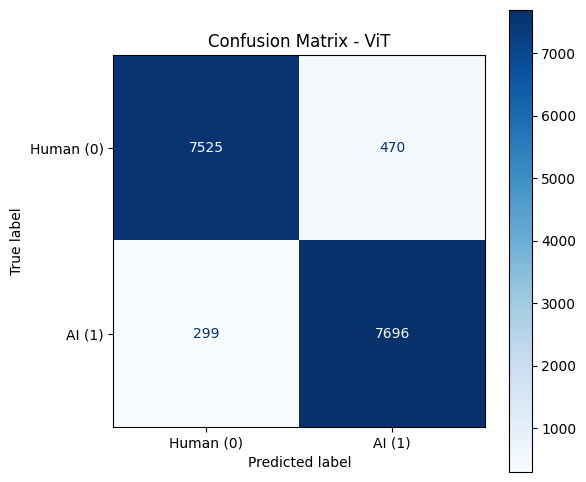

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = ['Human (0)', 'AI (1)']

print("\n--- Confusion Matrix ViT ---")
print(classification_report(all_val_labels_vit, all_val_preds_vit, target_names=target_names))

cm_vit = confusion_matrix(all_val_labels_vit, all_val_preds_vit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vit, display_labels=target_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='horizontal')
plt.title('Confusion Matrix - ViT')
plt.show()


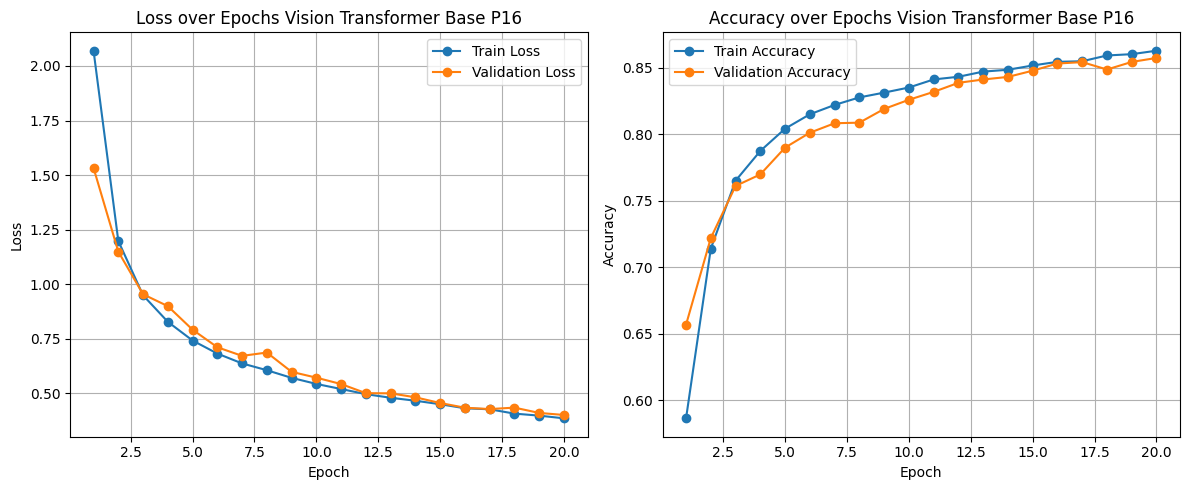

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses_vit, val_losses_vit, train_accuracies_vit, val_accuracies_vit):
    epochs = range(1, len(train_losses_vit) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_vit, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_vit, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs Vision Transformer Base P16')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies_vit, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies_vit, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs Vision Transformer Base P16')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_losses_eff, val_losses_eff, train_accuracies_eff, val_accuracies_eff)


In [ ]:
import matplotlib.pyplot as plt


epochs = list(range(1, 21))
train_loss = [0.3887, 0.2295, 0.1939, 0.1778, 0.1683, 0.1619, 0.1582, 0.1544, 0.1526, 0.1516,
              0.1491, 0.1486, 0.1475, 0.1468, 0.1470, 0.1459, 0.1449, 0.1449, 0.1440, 0.1460]
val_loss = [0.2446, 0.1879, 0.1673, 0.1549, 0.1471, 0.1431, 0.1380, 0.1375, 0.1340, 0.1337,
            0.1332, 0.1337, 0.1305, 0.1311, 0.1323, 0.1320, 0.1276, 0.1271, 0.1309, 0.1278]
train_acc = [0.8326, 0.9201, 0.9316, 0.9356, 0.9382, 0.9394, 0.9417, 0.9420, 0.9421, 0.9426,
             0.9437, 0.9437, 0.9438, 0.9440, 0.9431, 0.9437, 0.9440, 0.9441, 0.9444, 0.9441]
val_acc = [0.9150, 0.9358, 0.9417, 0.9448, 0.9469, 0.9482, 0.9500, 0.9497, 0.9507, 0.9507,
           0.9500, 0.9503, 0.9520, 0.9515, 0.9501, 0.9497, 0.9526, 0.9528, 0.9500, 0.9519]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(epochs, train_loss, marker='o', label='Train Loss', color='skyblue')
axs[0].plot(epochs, val_loss, marker='o', label='Val Loss', color='salmon')
axs[0].set_title('Train vs Validation Loss (ViT)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs, train_acc, marker='o', label='Train Accuracy', color='skyblue')
axs[1].plot(epochs, val_acc, marker='o', label='Val Accuracy', color='salmon')
axs[1].set_title('Train vs Validation Accuracy (ViT)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


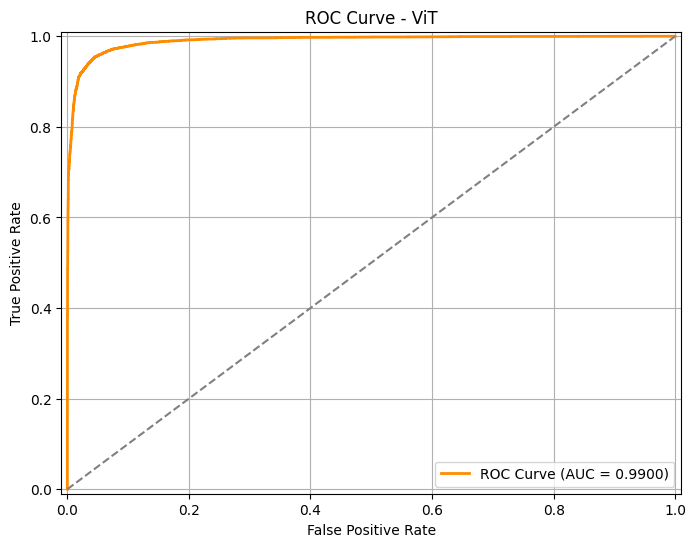

AUC Score (ViT): 0.9900


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, data_loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ViT')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc

roc_auc_vit = plot_roc_auc(model_vit, val_loader, device)
print(f"AUC Score (ViT): {roc_auc_vit:.4f}")


In [47]:
torch.save(model_vit.state_dict(), "ViTBase_model_new.pth")
print("Model ViT berhasil disimpan ke: ViTBase_model_new.pth")

history_vit = {
    "train_loss": train_losses_vit,
    "val_loss": val_losses_vit,  
    "train_acc": train_accuracies_vit,
    "val_acc": val_accuracies_vit
}
print("History ViT disimpan dalam variabel 'history_vit'")

Model ViT berhasil disimpan ke: ViTBase_model_new.pth
History ViT disimpan dalam variabel 'history_vit'


C:\Users\User\Documents\cherry\cherry-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


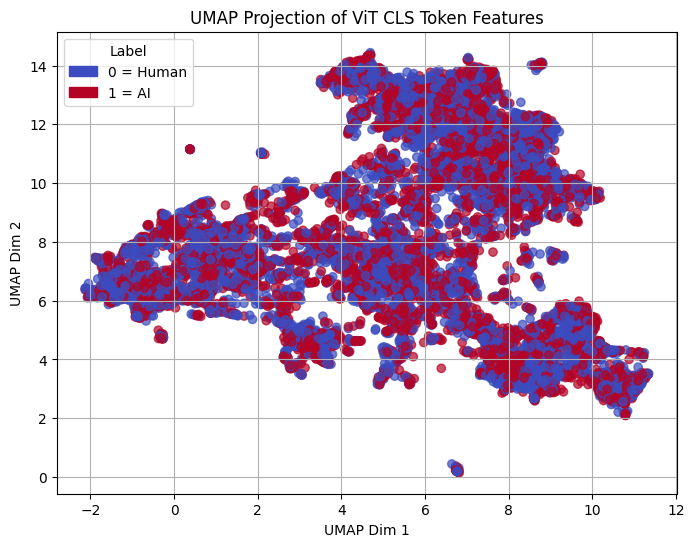

In [ ]:
features_vit = []
labels_vit = []

model_vit.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        feats = model_vit.forward_features(images) 
        feats = feats[:, 0, :] 

        features_vit.append(feats.cpu().numpy())
        labels_vit.extend(labels.cpu().numpy())

features_vit = np.concatenate(features_vit, axis=0)
labels_vit = np.array(labels_vit)

reducer = umap.UMAP(n_components=2, random_state=42)
features_umap_vit = reducer.fit_transform(features_vit)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_umap_vit[:, 0], features_umap_vit[:, 1],
    c=labels_vit, cmap='coolwarm', alpha=0.7
)
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.title("UMAP Projection of ViT CLS Token Features")
plt.grid(True)

legend_handles = [
    mpatches.Patch(color='#3b4cc0', label="0 = Human"),
    mpatches.Patch(color='#b40426', label="1 = AI")
]
plt.legend(handles=legend_handles, title="Label")
plt.show()

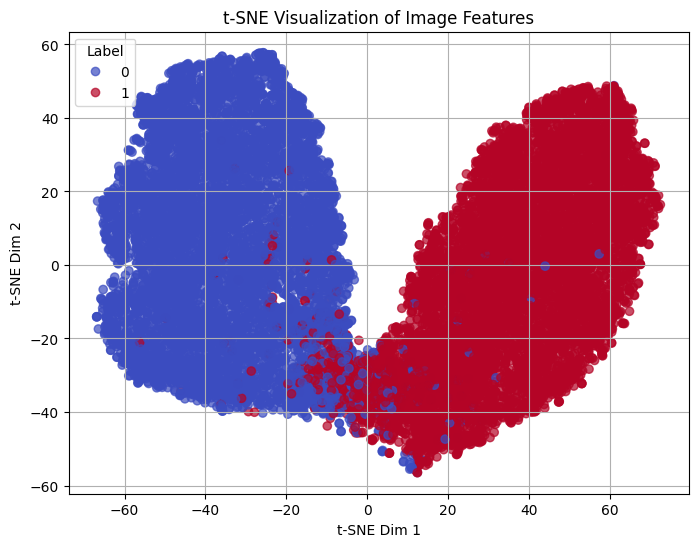

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = []
labels = []

model_cnn.eval()
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        label = label.to(device)
        
        feats = model_cnn.extract_features(images)
        feats = feats.view(feats.size(0), -1)
        features.append(feats.cpu().numpy())
        labels.append(label.cpu().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Label")
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

TSNE diambil berdasarkan backbone dari model. 

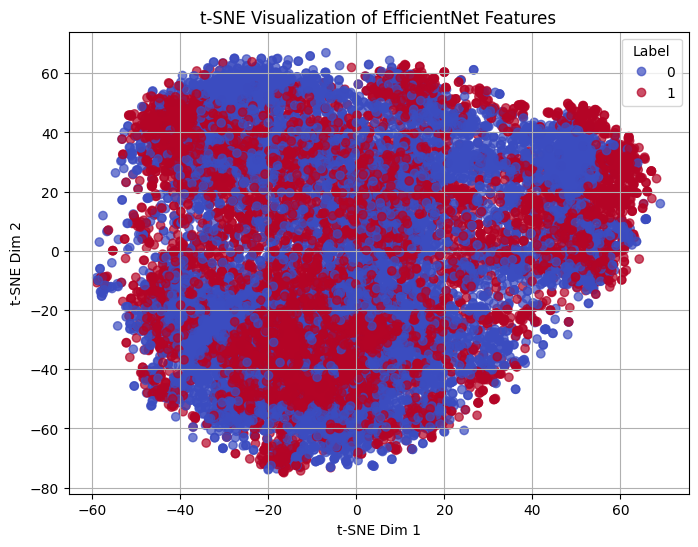

In [ ]:
features = []
labels = []

model_eff.eval()
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        label = label.to(device)

        feats = model_eff.forward_features(images)             
        feats = F.adaptive_avg_pool2d(feats, 1)                
        feats = feats.view(feats.size(0), -1)                  
        
        features.append(feats.cpu().numpy())
        labels.append(label.cpu().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Label")
plt.title("t-SNE Visualization of EfficientNet Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

In [ ]:
# features = np.concatenate(features, axis=0)
# labels = np.concatenate(labels, axis=0)

# if features.ndim > 2:
#     features = features.reshape(features.shape[0], -1)

# print("Final features shape:", features.shape)

# tsne = TSNE(n_components=2, random_state=42)
# features_2d = tsne.fit_transform(features)

In [ ]:
# PCA & TSNE MODEL EFFICIENTNET & VIT
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import numpy as np

# features = []
# labels = []

# model_eff.eval()
# with torch.no_grad():
#     for images, label in val_loader:
#         images = images.to(device)
#         label = label.to(device)

#         feats = model_eff.forward_features(images)  
#         feats = F.adaptive_avg_pool2d(feats, 1)
#         feats = feats.view(feats.size(0), -1)

        

#         features.append(feats.cpu().numpy())
#         labels.append(label.cpu().numpy())

# features = np.concatenate(features)
# labels = np.concatenate(labels)

# features_pca = PCA(n_components=50).fit_transform(features)

# features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features_pca)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
# plt.legend(*scatter.legend_elements(), title="Label")
# plt.title("PCA + t-SNE Projection")
# plt.xlabel("t-SNE Dim 1")
# plt.ylabel("t-SNE Dim 2")
# plt.grid(True)
# plt.show()

# model_vit.eval()
# with torch.no_grad():
#     for images, label in val_loader:
#         images = images.to(device)
#         label = label.to(device)

#         feats = model_vit.forward_features(images)  
#         feats = feats[:, 0, :]

#         features.append(feats.cpu().numpy())
#         labels.append(label.cpu().numpy())

# features = np.concatenate(features)
# labels = np.concatenate(labels)

# features_pca = PCA(n_components=50).fit_transform(features)

# features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features_pca)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
# plt.legend(*scatter.legend_elements(), title="Label")
# plt.title("PCA + t-SNE Projection")
# plt.xlabel("t-SNE Dim 1")
# plt.ylabel("t-SNE Dim 2")
# plt.grid(True)
# plt.show()

Menyimpan nilai probabilitas dan true dalam ketiga model yang digunakan untuk visualisasi metrix evaluasi

In [ ]:
y_true_cnn = []
y_probs_cnn = []

model_cnn.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_cnn(images)
        probs = torch.softmax(outputs, dim=1)[:, 1] 

        y_true_cnn.extend(labels.cpu().numpy())
        y_probs_cnn.extend(probs.cpu().numpy())

y_true_cnn = np.array(y_true_cnn)
y_probs_cnn = np.array(y_probs_cnn)

In [56]:
y_true_eff = []
y_probs_eff = []

model_eff.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_eff(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        y_true_eff.extend(labels.cpu().numpy())
        y_probs_eff.extend(probs.cpu().numpy())

y_true_eff = np.array(y_true_eff)
y_probs_eff = np.array(y_probs_eff)

In [57]:
y_true_vit = []
y_probs_vit = []

model_vit.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_vit(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        y_true_vit.extend(labels.cpu().numpy())
        y_probs_vit.extend(probs.cpu().numpy())

y_true_vit = np.array(y_true_vit)
y_probs_vit = np.array(y_probs_vit)

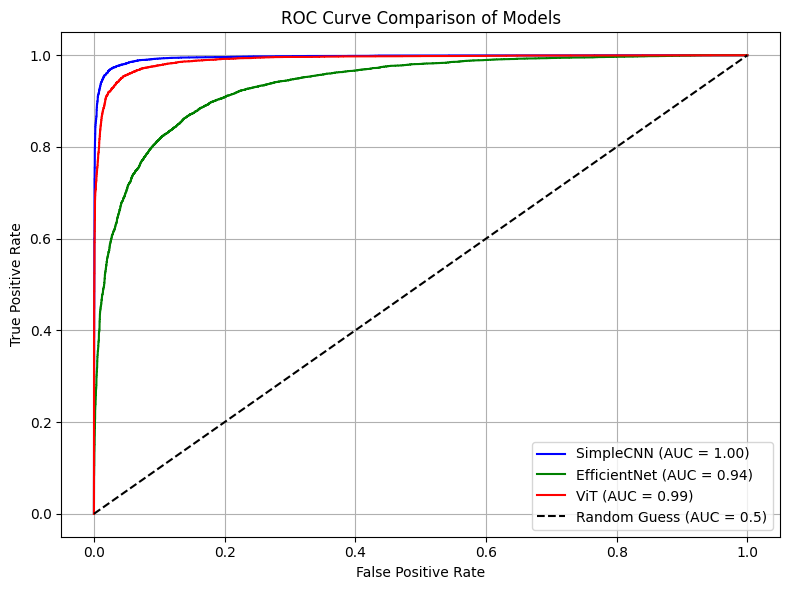

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, y_probs_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_eff, tpr_eff, _ = roc_curve(y_true_eff, y_probs_eff)
auc_eff = auc(fpr_eff, tpr_eff)

fpr_vit, tpr_vit, _ = roc_curve(y_true_vit, y_probs_vit)
auc_vit = auc(fpr_vit, tpr_vit)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f"SimpleCNN (AUC = {auc_cnn:.2f})", color="blue")
plt.plot(fpr_eff, tpr_eff, label=f"EfficientNet (AUC = {auc_eff:.2f})", color="green")
plt.plot(fpr_vit, tpr_vit, label=f"ViT (AUC = {auc_vit:.2f})", color="red")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# display_test_predictions(model_vit, test_loader, device, target_names=['Human', 'AI'], model_name="ViT Base")

<h3>TESTING DATA DARI LUAR DATASET

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

label_map = {0: "Human", 1: "AI"}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


test_folder = "dataset/test_data_mix/"
model_cnn.eval()

results = []

for file in sorted(os.listdir(test_folder)):
    if file.endswith(".jpg") or file.endswith(".png"):
        img_path = os.path.join(test_folder, file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model_cnn(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_class].item()

        results.append({
            "filename": file,
            "predicted_label": pred_class,
            "predicted_name": label_map[pred_class],
            "confidence": f"{confidence*100:.2f} %"
        })


df_preds = pd.DataFrame(results)
print(df_preds)


                                      filename  predicted_label  \
0         13efa1d73c844321881a8b933df1373b.jpg                0   
1         14d3aa154b8043708ec7527c6b9496cd.jpg                0   
2         14fd1e222c9f4803a545485bd44638d6.jpg                0   
3         15d4cdfbd9934cbea4d721d4a0ae0cdd.jpg                0   
4         15dcc726927942ba88e467af8645b03e.jpg                0   
5  Gemini_Generated_Image_atgz7ratgz7ratgz.png                0   
6  Gemini_Generated_Image_njvx2bnjvx2bnjvx.png                1   
7  Gemini_Generated_Image_nr12vgnr12vgnr12.png                0   
8  Gemini_Generated_Image_pu39fxpu39fxpu39.png                1   
9  Gemini_Generated_Image_vsp67cvsp67cvsp6.png                0   

  predicted_name confidence  
0          Human    96.67 %  
1          Human   100.00 %  
2          Human    98.12 %  
3          Human   100.00 %  
4          Human   100.00 %  
5          Human   100.00 %  
6             AI    90.19 %  
7          Human   100

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

label_map = {0: "Human", 1: "AI"}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_folder = "dataset/test_data_mix/"
model_eff.eval()

results = []

for file in sorted(os.listdir(test_folder)):
    if file.endswith(".jpg") or file.endswith(".png"):
        img_path = os.path.join(test_folder, file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model_eff(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_class].item()

        results.append({
            "filename": file,
            "predicted_label": pred_class,
            "predicted_name": label_map[pred_class],
            "confidence": f"{confidence*100:.2f} %"
        })

df_preds = pd.DataFrame(results)
print(df_preds)


                                      filename  predicted_label  \
0         13efa1d73c844321881a8b933df1373b.jpg                0   
1         14d3aa154b8043708ec7527c6b9496cd.jpg                0   
2         14fd1e222c9f4803a545485bd44638d6.jpg                1   
3         15d4cdfbd9934cbea4d721d4a0ae0cdd.jpg                0   
4         15dcc726927942ba88e467af8645b03e.jpg                0   
5  Gemini_Generated_Image_atgz7ratgz7ratgz.png                1   
6  Gemini_Generated_Image_njvx2bnjvx2bnjvx.png                1   
7  Gemini_Generated_Image_nr12vgnr12vgnr12.png                0   
8  Gemini_Generated_Image_pu39fxpu39fxpu39.png                1   
9  Gemini_Generated_Image_vsp67cvsp67cvsp6.png                0   

  predicted_name confidence  
0          Human    88.97 %  
1          Human    90.58 %  
2             AI    89.11 %  
3          Human    99.99 %  
4          Human    99.93 %  
5             AI    99.94 %  
6             AI    99.92 %  
7          Human    93

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

label_map = {0: "Human", 1: "AI"}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_folder = "dataset/test_data_mix/"
model_vit.eval()

results = []

for file in sorted(os.listdir(test_folder)):
    if file.endswith(".jpg") or file.endswith(".png"):
        img_path = os.path.join(test_folder, file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model_vit(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_class].item()

        results.append({
            "filename": file,
            "predicted_label": pred_class,
            "predicted_name": label_map[pred_class],
            "confidence": f"{confidence*100:.2f} %"
        })

df_preds = pd.DataFrame(results)
print(df_preds)


                                      filename  predicted_label  \
0         13efa1d73c844321881a8b933df1373b.jpg                0   
1         14d3aa154b8043708ec7527c6b9496cd.jpg                1   
2         14fd1e222c9f4803a545485bd44638d6.jpg                1   
3         15d4cdfbd9934cbea4d721d4a0ae0cdd.jpg                0   
4         15dcc726927942ba88e467af8645b03e.jpg                0   
5  Gemini_Generated_Image_atgz7ratgz7ratgz.png                0   
6  Gemini_Generated_Image_njvx2bnjvx2bnjvx.png                1   
7  Gemini_Generated_Image_nr12vgnr12vgnr12.png                0   
8  Gemini_Generated_Image_pu39fxpu39fxpu39.png                1   
9  Gemini_Generated_Image_vsp67cvsp67cvsp6.png                1   

  predicted_name confidence  
0          Human    92.03 %  
1             AI    66.70 %  
2             AI    92.53 %  
3          Human    99.67 %  
4          Human    99.43 %  
5          Human    98.49 %  
6             AI    94.13 %  
7          Human    58

In [68]:
print("--- Training Data Info ---")
df_train.info()
print("\n--- Training Data Head ---")
print(df_train.head())
print("\n--- Training Data Null Values ---")
print(df_train.isnull().sum())
print("\n--- Training Data Duplicated Values ---")
print(df_train.duplicated().sum())

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
 3   file_path   79950 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.4+ MB

--- Training Data Head ---
   Unnamed: 0                                        file_name  label  \
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1   
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0   
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1   
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0   
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1   

                                           file_path  
0  dataset/train_data\a6dcb93f596a43249135678dfcf... 

In [69]:
df_train.describe()

,Unnamed: 0,label
count,79950.000000,79950.000000
mean,39974.500000,0.500000
std,23079.721348,0.500003
min,0.000000,0.000000
25%,19987.250000,0.000000
50%,39974.500000,0.500000
75%,59961.750000,1.000000
max,79949.000000,1.000000


Pengecekan menggunakan efficientNet dan Vision Transformer tanpa pretrain (fine tuning) 

In [70]:
import timm
import torch.nn as nn

model_eff2 = timm.create_model("efficientnet_b0", pretrained=False, num_classes=2)

# Freeze semua layer kecuali classifier
for param in model_eff2.parameters():
    param.requires_grad = True

for param in model_eff.classifier.parameters():
    param.requires_grad = True

model_eff2 = model_eff2.to(device)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer_eff2 = torch.optim.Adam(model_eff2.classifier.parameters(), lr=1e-4)

In [ ]:
train_losses_eff2 = []
val_losses_eff2 = []
train_accuracies_eff2 = []
val_accuracies_eff2 = []

for epoch in range(num_epochs):
    model_eff2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [EfficientNet Training]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_eff2(images)
        loss = criterion(outputs, labels)

        optimizer_eff2.zero_grad()
        loss.backward()
        optimizer_eff2.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_eff2.append(epoch_train_loss)
    train_accuracies_eff2.append(epoch_train_acc)

    # Validation Phase
    model_eff2.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds_eff2 = []
    all_val_labels_eff2 = []

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [EfficientNet Validation]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model_eff2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_val_preds_eff2.extend(predicted.cpu().numpy())
            all_val_labels_eff2.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_eff2.append(epoch_val_loss)
    val_accuracies_eff2.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Training EfficientNet Selesai! 🎉")

Epoch 1/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:36<00:00,  1.81it/s, val_loss=0.424, val_acc=0.864]


Epoch [1/20] | Train Loss: 0.5714 | Train Acc: 0.7488 | Val Loss: 0.5817 | Val Acc: 0.7360


Epoch 2/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:30<00:00,  1.85it/s, val_loss=0.415, val_acc=0.864]


Epoch [2/20] | Train Loss: 0.5497 | Train Acc: 0.7615 | Val Loss: 0.5712 | Val Acc: 0.7446


Epoch 3/20 [EfficientNet Validation]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:32<00:00,  1.84it/s, val_loss=0.43, val_acc=0.864]


Epoch [3/20] | Train Loss: 0.5369 | Train Acc: 0.7659 | Val Loss: 0.5717 | Val Acc: 0.7634


Epoch 4/20 [EfficientNet Validation]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:31<00:00,  1.84it/s, val_loss=0.457, val_acc=0.864]


Epoch [4/20] | Train Loss: 0.5274 | Train Acc: 0.7683 | Val Loss: 0.5683 | Val Acc: 0.7483


Epoch 5/20 [EfficientNet Training]:   3%|████                                                                                                                              | 63/1999 [01:20<41:23,  1.28s/it, loss=0.341, acc=0.844]

In [ ]:
print("\n--- Confusion Matrix EfficientNet NON PRETRAIN ---")
print(classification_report(all_val_labels_eff2, all_val_preds_eff2, target_names=['Human (0)', 'AI (1)']))

cm_eff2 = confusion_matrix(all_val_labels_eff2, all_val_preds_eff2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eff2, display_labels=['Human (0)', 'AI (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='horizontal')
plt.title('Confusion Matrix - EfficientNet NON PRETRAIN')
plt.show()

In [ ]:
roc_auc_eff2 = plot_roc_auc(model_eff2, val_loader, device)
print(f"AUC Score (EfficientNet): {roc_auc_eff2:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses_eff2, val_losses_eff2, train_accuracies_eff2, val_accuracies_eff2):
    epochs = range(1, len(train_losses_eff2) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_eff2, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_eff2, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs EfficientNet B0 [2]')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies_eff2, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies_eff2, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs EfficientNet B0 [2]')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_losses_eff2, val_losses_eff2, train_accuracies_eff2, val_accuracies_eff2)


In [ ]:
import timm
import torch.nn as nn

model_vit2 = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=2)

# Freeze semua kecuali head
for param in model_vit2.parameters():
    param.requires_grad = False

for param in model_vit2.head.parameters():
    param.requires_grad = True

model_vit2 = model_vit2.to(device)

# Optimizer dan loss
criterion = nn.CrossEntropyLoss()
optimizer_vit2 = torch.optim.Adam(model_vit2.head.parameters(), lr=1e-4)

In [ ]:
train_losses_vit2 = []
val_losses_vit2 = []
train_accuracies_vit2 = []
val_accuracies_vit2 = []

for epoch in range(num_epochs):
    model_vit2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VIT Training]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model_vit2(images)
        loss = criterion(outputs, labels)

        optimizer_vit2.zero_grad()
        loss.backward()
        optimizer_vit2.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_vit2.append(epoch_train_loss)
    train_accuracies_vit2.append(epoch_train_acc)

    # Validation Phase
    model_vit2.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds_vit2 = []
    all_val_labels_vit2 = []

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VIT Validation]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model_vit2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_val_preds_vit2.extend(predicted.cpu().numpy())
            all_val_labels_vit2.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted == labels).sum().item()/images.size(0)})

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_vit2.append(epoch_val_loss)
    val_accuracies_vit2.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Training VIT NON PRETRAIN Selesai! 🎉")

In [ ]:
print("\n--- Confusion Matrix VIT NON PRETRAIN ---")
print(classification_report(all_val_labels_vit2, all_val_preds_vit2, target_names=['Human (0)', 'AI (1)']))

cm_vit2 = confusion_matrix(all_val_labels_vit2, all_val_preds_vit2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vit2, display_labels=['Human (0)', 'AI (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='horizontal')
plt.title('Confusion Matrix - VIT NON PRETRAIN')
plt.show()

In [ ]:
roc_auc_vit2 = plot_roc_auc(model_vit2, val_loader, device)
print(f"AUC Score (VIT): {roc_auc_vit2:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses_vit2, val_losses_vit2, train_accuracies_vit2, val_accuracies_vit2):
    epochs = range(1, len(train_losses_vit2) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_vit2, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_vit2, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs VIT [2]')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies_vit2, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies_vit2, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs VIT [2]')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_losses_vit2, val_losses_vit2, train_accuracies_vit2, val_accuracies_vit2)


In [ ]:
torch.save(model_vit.state_dict(), "ViTBase_model_new_nopretrain.pth")
print("Model ViT berhasil disimpan ke: ViTBase_model_new.pth")

history_vit = {
    "train_loss": train_losses_vit,
    "val_loss": val_losses_vit,  
    "train_acc": train_accuracies_vit,
    "val_acc": val_accuracies_vit
}
print("History ViT disimpan dalam variabel 'history_vit'")

In [ ]:
torch.save(model_vit.state_dict(), "EN-B0-nopretrain.pth")
print("Model EN berhasil disimpan ke: EN-B0-nopretrain.pth")

history_eff2 = {
    "train_loss": train_losses_eff2,
    "val_loss": val_losses_eff2,  
    "train_acc": train_accuracies_eff2,
    "val_acc": val_accuracies_eff2
}
print("History EN disimpan dalam variabel 'history_eff_2'")